In [254]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


**1. Reading Data, General Analysis**

In [255]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [256]:
df.shape

(5110, 12)

In [257]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [258]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [259]:
#Cleaning Procedure
missing_mean = df["bmi"].mean()
df.fillna(missing_mean, inplace=True)
df = df.drop(['id'], axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


**2. Exploratory Data Analysis**

In [260]:
#Exploring the proportion of positive and negative singnal throughout the dataset
print(df["stroke"].value_counts())
print(f'Proportion of individuals with negative signal: {4860/len(df)}')

stroke
0    4861
1     249
Name: count, dtype: int64
Proportion of individuals with negative signal: 0.9510763209393346


Text(0.5, 1.0, 'Distribution of Ages in Positive and Negative Signals')

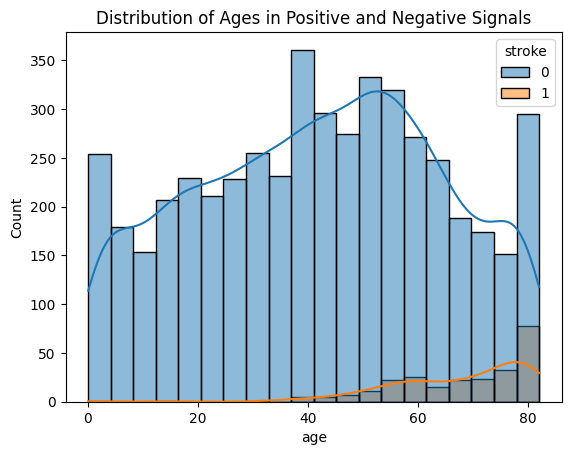

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data = df, x = 'age', kde = True, hue = 'stroke')
plt.title("Distribution of Ages in Positive and Negative Signals")

Based on the visualization highlighting age, it is evident that datapoints with a positive signal tend to be distributed on the older side.

Text(0.5, 1.0, 'Distribution of Ages in Positive and Negative Signals')

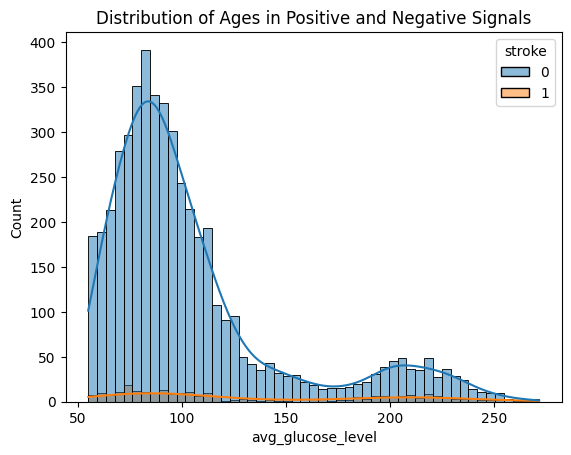

In [262]:
sns.histplot(data = df, x = 'avg_glucose_level', kde = True, hue = 'stroke')
plt.title("Distribution of Ages in Positive and Negative Signals")

Based on the visalization plotting average glucose levels, it seems that datapoints with a positive signal are roughly evenly distributed in age. Conversely, the distribution of those negative in signal is skewed to the right.

Text(0.5, 1.0, 'Distribution of Ages in Positive and Negative Signals')

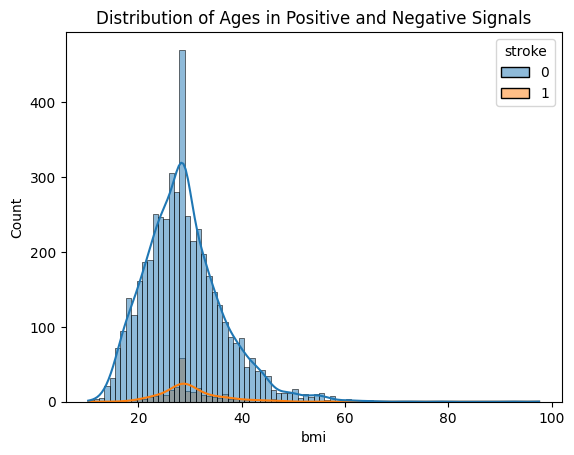

In [263]:
sns.histplot(data = df, x = 'bmi', kde = True, hue = 'stroke')
plt.title("Distribution of Ages in Positive and Negative Signals")

From the visualization, it seems that the both signals, positive and negative, are evenly distributed. However, it appears that the distribution of those that do not have CVA is skewed to the right. While it might be unecessary to leave this feature in the design matrix, we can conclude a stronger probability of a negative signal if the model recieves data points exceeding 60 points on bmi.

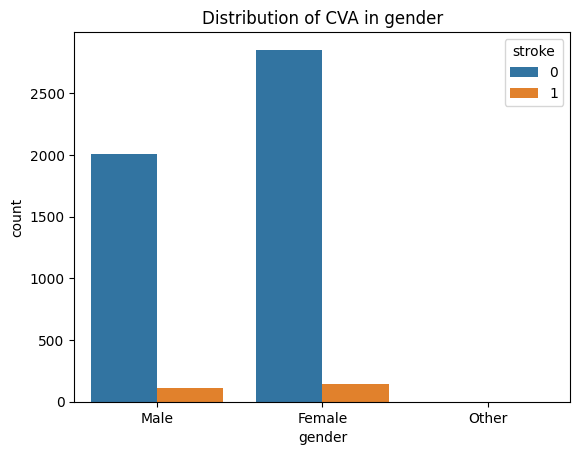

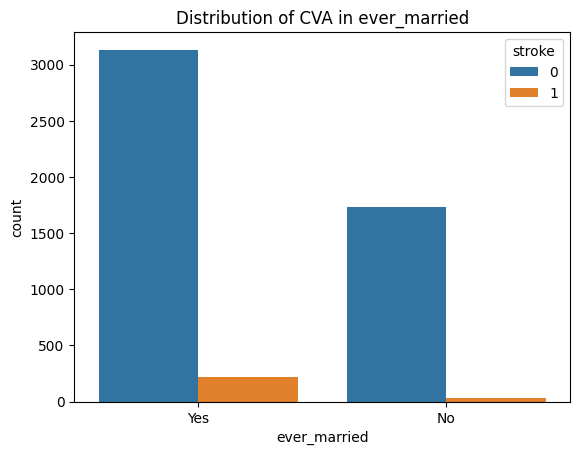

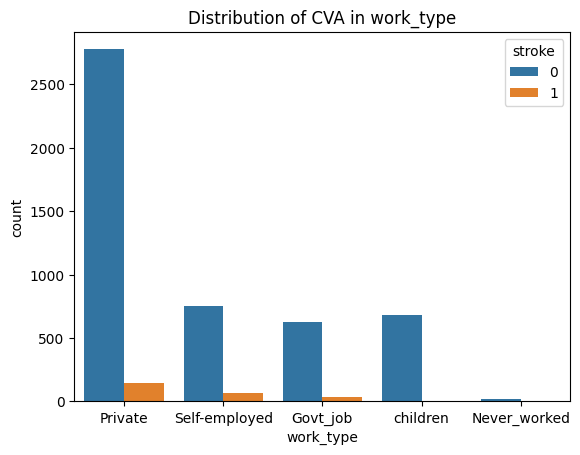

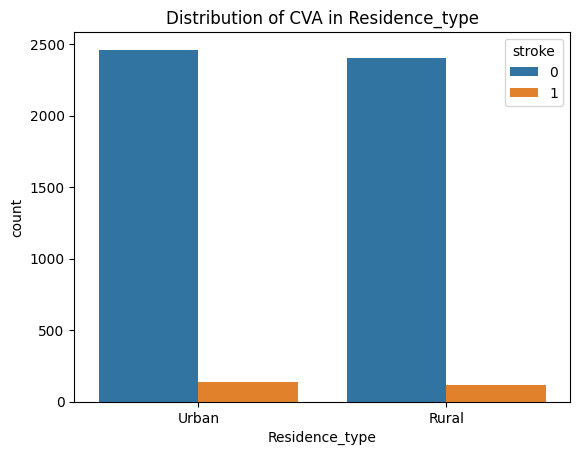

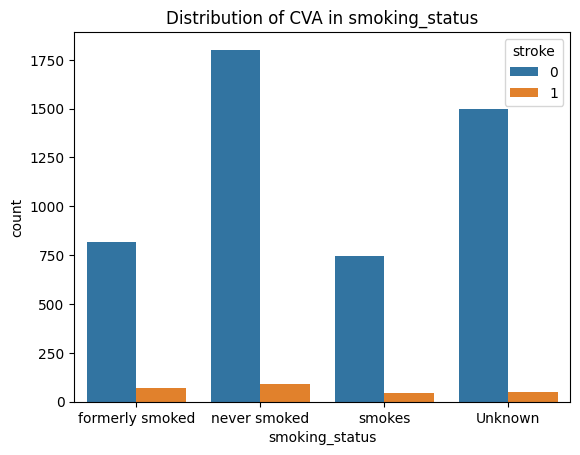

In [264]:
#Exploration of categorical variables 
categorical_variables = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for cat in categorical_variables:
    sns.countplot(df, x = cat, hue = "stroke")
    plt.title(f"Distribution of CVA in {cat}")
    plt.show()

**3. One Hot Encoding, Feature Engineering**

In [265]:
for cat in categorical_variables:
    print(df[cat].value_counts(),"\n")

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64 

ever_married
Yes    3353
No     1757
Name: count, dtype: int64 

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64 

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64 

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64 



In [266]:
#Eliminating the 'other' category in gender for simplicity
df = df[(df["gender"] == 'Male') | (df["gender"] == 'Female')]

One hot encoding function:
- Uses get_dummies to perform one-hot encoding 
- Concateate the original DataFrame and the one-hot encoded DataFrame
- Drop the original column as it's no longer needed

In [267]:
def one_hot_encode_column(df, column_name):
    one_hot_encoded = pd.get_dummies(df[column_name], prefix=column_name).astype(int)
    df = pd.concat([df, one_hot_encoded], axis=1)
    df = df.drop(column_name, axis=1)
    return df

In [268]:
for cat in categorical_variables:
    df = one_hot_encode_column(df, cat)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.893237,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.000000,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0


In [269]:
from sklearn.model_selection import train_test_split
X = df.drop(["stroke"], axis = 1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

**4. Standard Scaling**

In [270]:
# Implementing standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**5. Decision Tree Classifier**

In [277]:
from sklearn import tree
tr = tree.DecisionTreeClassifier(random_state = 0)
tr.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [280]:
tr_preds = tr.predict(X_test)
tr_accuracy = sum(tr_preds == y_test)/len(y_test)
print(f'Decision tree accuracy: {tr_accuracy}')

Decision tree accuracy: 0.9050880626223092


**6. Random Forest Classification**

Parameters:
- Max depth: 2

In [281]:
from pprint import pprint
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 644, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [282]:
from sklearn.model_selection import RandomizedSearchCV
#Creating a parameter grid for tuning 
# Trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in range(2, 9, 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [ ]:
#Commenting out the GridSearch, takes too long to run and is crashing my computer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#clf = RandomForestClassifier(random_state = 0)
#rscv = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rscv.fit(X_train, y_train)

In [ ]:
#rscv.best_params_
print('Best parameters output from GridSearchCV:')
print('n_estimators = 644, min_samples_split = 5, min_samples_leaf = 2, max_depth= 6, random_state=0, bootstrap = False')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators = 644, min_samples_split = 5, min_samples_leaf = 2, max_depth= 6, random_state=0, bootstrap = False)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

**7. Random Forest Classifier Evaluations**

In [ ]:
#Quick check for accuracy 
sum(prediction == y_test)/len(y_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#Classification report
print(classification_report(y_test, prediction, zero_division = 0))

In [ ]:
#Confusion Matrix Code 
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g',cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**8. Application of Synthetic Minority Oversampling Techniques (SMOTE) on Random Forest Classifier**

In [283]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [284]:
smote_classifier = RandomForestClassifier(n_estimators = 644, min_samples_split = 5, min_samples_leaf = 2, max_depth= 6, random_state=0, bootstrap = False)
smote_classifier.fit(X_train_smote, y_train_smote)
smote_prediction = smote_classifier.predict(X_test)

In [285]:
print(classification_report(smote_prediction, y_test))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3516
           1       0.35      0.13      0.19       572

    accuracy                           0.84      4088
   macro avg       0.61      0.54      0.55      4088
weighted avg       0.80      0.84      0.81      4088



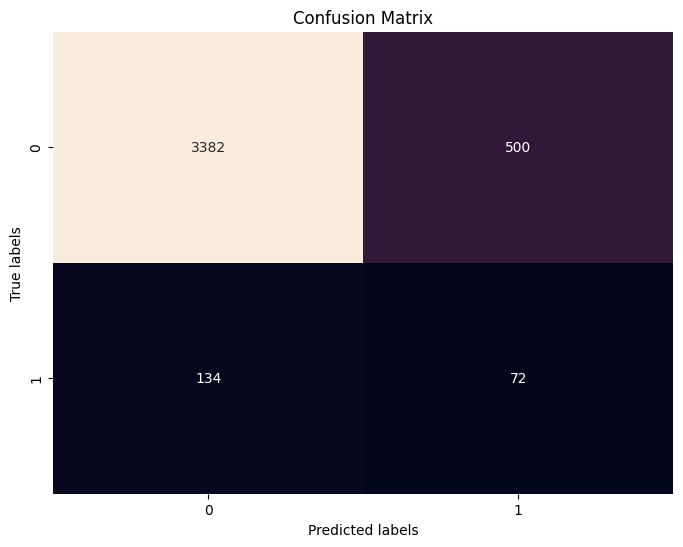

In [286]:
smote_cm = confusion_matrix(y_test, smote_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(smote_cm, annot=True, fmt='g',cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()